<a href="https://colab.research.google.com/github/Rus-tam/daniel_bourke_course/blob/main/04_Transfer_Learning_with_TensorFlow_Part_1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Transfer Learning with TensorFlow Part 1: Feature Extraction

We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called transfer learning, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

Can leverage an existing neural network architecture proven to work on problems similar to our own.
Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.
What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

## What we're going to cover

We're going to go through the following with TensorFlow:

* Introduce transfer learning (a way to beat all of our old self-built models)
* Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
* Build a transfer learning feature extraction model using TensorFlow Hub
* Introduce the TensorBoard callback to track model training results
* Compare model results using TensorBoard

## Downloading and becoming one with the data

In [2]:
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrap

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-03-25 10:44:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.2MB/s    in 8.1s    

2025-03-25 10:45:07 (19.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Creating data loaders (preparing the data)
Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [1]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMAGE_SHAPE,
                                          seed=42)

test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SHAPE,
                                         seed=42)

# Нормализация входных данных
normalization_layer = layers.Rescaling(1./255)

# Применяем нормализацию к данным
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)¶

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoin with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [2]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")

    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've use TensorFlow to create our own models layers by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come fro TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://www.kaggle.com/models/google/resnet-v2/tensorFlow2

In [3]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow import keras

In [5]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Web feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [6]:
import tf_keras as tfk

def create_model_from_a_url(url: str, num_classes=10):
    """
    Takes a tensorflow hub URL and creates a tensorflow Sequential model with it.
    Returns:
        -> an uncompiled model
    """
    feature_extractor_layer = hub.KerasLayer(
        url,
        trainable=False,
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE + (3,)
    )
    print(" ")
    print(feature_extractor_layer)
    print(" ")

    model = keras.Sequential([
        feature_extractor_layer,
        keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [7]:
# Create Resnet model
resnet_model = create_model_from_a_url(url=resnet_url, num_classes=10)
resnet_model.build((None,) + IMAGE_SHAPE + (3,))
resnet_model.summary()

 
 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [8]:
# Compile our resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [9]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250325-104633
Epoch 1/5
24/24 [==============================] - 311s 13s/step - loss: 1.8443 - accuracy: 0.3707 - val_loss: 1.1848 - val_accuracy: 0.6228
Epoch 2/5
24/24 [==============================] - 332s 14s/step - loss: 0.8789 - accuracy: 0.7333 - val_loss: 0.8622 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 307s 13s/step - loss: 0.6143 - accuracy: 0.8320 - val_loss: 0.7771 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 332s 14s/step - loss: 0.4652 - accuracy: 0.8853 - val_loss: 0.7025 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 330s 14s/step - loss: 0.3661 - accuracy: 0.9200 - val_loss: 0.6922 - val_accuracy: 0.7712


In [10]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 227s 3s/step - loss: 0.6922 - accuracy: 0.7712


[0.6922006607055664, 0.7712000012397766]

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we build by hand... (substantially) and in a quicker training time AND with only 10% of the training examples

In [15]:
import matplotlib.pyplot as plt

# Let's create a function to plot our loss curves....
# Tidbit: you could put a function like this into a script called 'helper.py' and import it when you need it...

# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training ans validation metrics.

    Args:
      history: TensorFlow History object.

    Returns:
      Plots of training/validation loss and accuracy metrics.
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history["loss"])) # how many epochs did we run for?

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend();

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend();

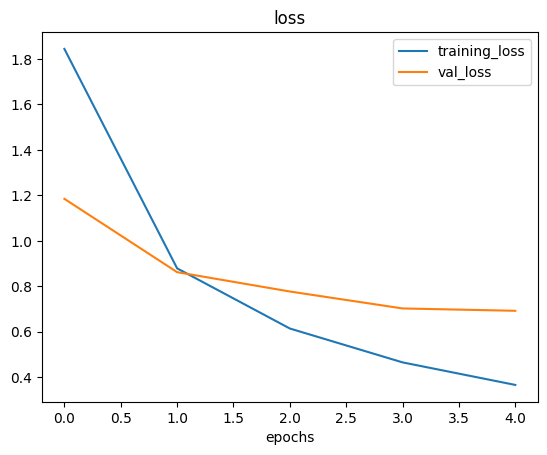

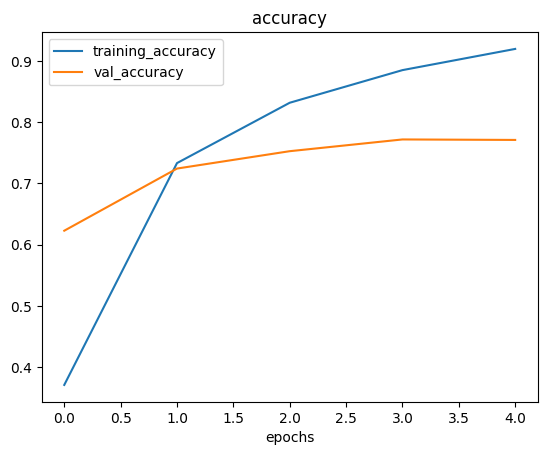

In [16]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [18]:
# Create EfficientNetB0 model
efficientnet_model = create_model_from_a_url(url=efficientnet_url, num_classes=10)
efficientnet_model.build((None,) + IMAGE_SHAPE + (3,))
efficientnet_model.summary()

 
 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [19]:
# Compile our efficientnet model
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [20]:
# Let's fit our EfficientNet model to the data (10 percent of 10 classes)
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="EfficientNetB0")])

Saving TensorBoard log files to: tensorflow_hub/EfficientNetB0/20250325-113334
Epoch 1/5
24/24 [==============================] - 194s 8s/step - loss: 1.8809 - accuracy: 0.4187 - val_loss: 1.2888 - val_accuracy: 0.7508
Epoch 2/5
24/24 [==============================] - 181s 8s/step - loss: 1.0564 - accuracy: 0.7893 - val_loss: 0.8541 - val_accuracy: 0.8332
Epoch 3/5
24/24 [==============================] - 181s 8s/step - loss: 0.7524 - accuracy: 0.8413 - val_loss: 0.6871 - val_accuracy: 0.8528
Epoch 4/5
24/24 [==============================] - 183s 8s/step - loss: 0.6033 - accuracy: 0.8707 - val_loss: 0.6001 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 184s 8s/step - loss: 0.5133 - accuracy: 0.8973 - val_loss: 0.5476 - val_accuracy: 0.8696


In [21]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 129s 2s/step - loss: 0.5476 - accuracy: 0.8696


[0.5475666522979736, 0.8695999979972839]

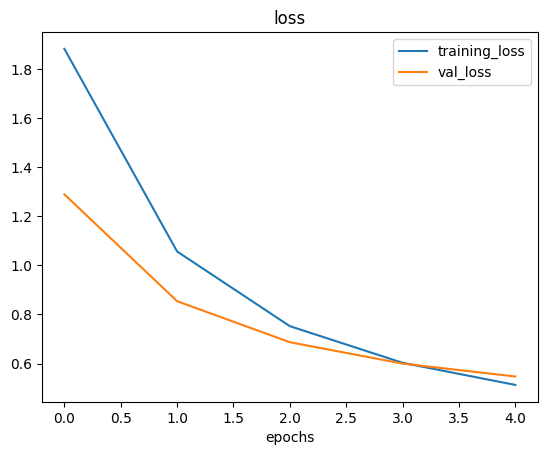

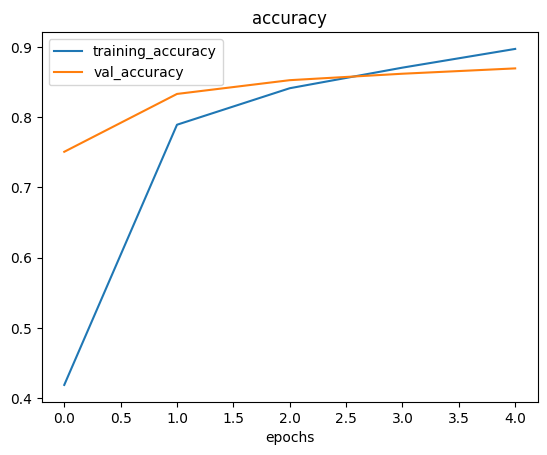

In [22]:
plot_loss_curves(efficientnet_history)